In [18]:
import numpy as np
import ceo
import M1S_tools as t
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import griddata
from scipy.ndimage import rotate

In [2]:
# entrance pupil sampling
n_px = 512  #*8 #each measured seg is 853pixels
L = 25.5

In [3]:
gmt = ceo.GMT_MX()
src = ceo.Source('V',rays_box_size=L,rays_box_sampling=n_px)
src>>(gmt,)
+src
pssn0 ,pssn_data = gmt.PSSn(src,save=True)

In [4]:
# "ideal" GMT WFE RMS [nm] & PSSn
src.wavefront.rms(-9),pssn0

(array([0.76414394], dtype=float32), array([1.]))

## Read in a polishing error map

In [5]:
segment_n_px = 990 #this is the largest grid so far out of RFCML
h5file = ['GMT1 120814-15 cor avg resamp 10mm stitched -27modes.h5',
        'GMT2 avg stitched -27modes.h5',
        'GMT3 221011 221014 avg TPavgStitched -27modes.h5',
         'GMT3 221011 221014 avg TPavgStitched -27modes.h5',
         'GMT3 221011 221014 avg TPavgStitched -27modes.h5',
         'GMT3 221011 221014 avg TPavgStitched -27modes.h5',
         'GMT3 221011 221014 avg TPavgStitched -27modes.h5']
for i in range(7):
    m1s,centerRow,centerCol,pixelSize = t.readH5Map([h5file[i]])
    [x, y] = t.mkXYGrid(m1s, centerRow, centerCol, pixelSize)
    print(i, m1s.shape, centerRow, centerCol, pixelSize, end = '   ')
    print(np.max(x)- np.min(x), np.max(y)- np.min(y))
    if m1s.shape[0]< segment_n_px: 
        #get the smallest map, and all others need to shrink to match
        #if we get the largest map, the smaller one will need to be extrapolated which is very tricky
        #even the smallest is larger than the Clear Aperture, so we are good!
        segment_n_px = m1s.shape[0]
        xm = x.copy()
        ym = y.copy()
m1sArray = np.zeros((segment_n_px, segment_n_px, 7))

GMT1 120814-15 cor avg resamp 10mm stitched -27modes.h5: date not in h5 file. 
0 (853, 853) [427.] [427.] [0.01]   8.52 8.52
GMT2 avg stitched -27modes.h5: date not in h5 file. 
1 (853, 853) [427.] [427.] [0.01]   8.52 8.52
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
2 (843, 843) [422.] [422.] [0.01]   8.42 8.42
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
3 (843, 843) [422.] [422.] [0.01]   8.42 8.42
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
4 (843, 843) [422.] [422.] [0.01]   8.42 8.42
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
5 (843, 843) [422.] [422.] [0.01]   8.42 8.42
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
6 (843, 843) [422.] [422.] [0.01]   8.42 8.42


In [11]:
for i in range(7):
    m1s,centerRow,centerCol,pixelSize = t.readH5Map([h5file[i]])
    [x, y] = t.mkXYGrid(m1s, centerRow, centerCol, pixelSize)
    idx = ~np.isnan(m1s)
    m1sArray[:,:,i] = griddata(np.vstack((x[idx], y[idx])).transpose(), m1s[idx], (xm, ym), method='nearest')

GMT1 120814-15 cor avg resamp 10mm stitched -27modes.h5: date not in h5 file. 
GMT2 avg stitched -27modes.h5: date not in h5 file. 
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 
GMT3 221011 221014 avg TPavgStitched -27modes.h5: date not in h5 file. 


In [7]:
np.max(xm), np.min(xm), np.max(ym), np.min(ym)

(4.21, -4.21, 4.21, -4.21)

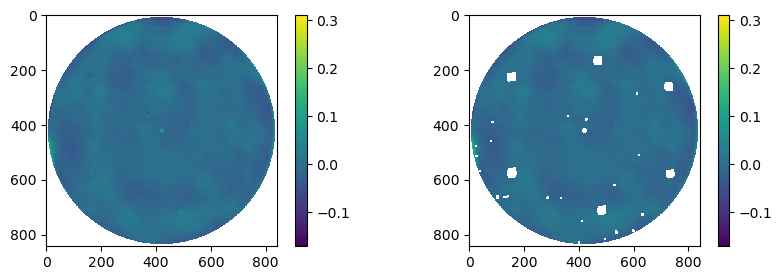

In [13]:
segment_L = np.max(xm)-np.min(xm)
segment_clear_aperture = 8.365
u = np.linspace(-1,1,segment_n_px)
x,y = np.meshgrid(u,u)
r = np.hypot(x,y)
o = np.arctan2(y,x)
phase_map = m1s

mask = np.ones_like(r)
mask[r>(segment_clear_aperture/segment_L)] = np.nan
fig, ax = plt.subplots(1,2, figsize=(10,3))
h = ax[0].imshow(m1sArray[:,:,2]*mask)
fig.colorbar(h,ax=ax[0])

h = ax[1].imshow(m1s*mask)
fig.colorbar(h,ax=ax[1])

In [20]:
phase_map7 = np.zeros((segment_n_px, segment_n_px, 7))
rotation_angles = [0, 0, 0, 20, 50, 199, 322] #random rotations
for i, angle in enumerate(rotation_angles):
    phase_map7[:,:,i] = rotate(m1sArray[:,:,i], angle, reshape=False)

In [21]:
# writing to the "CEO" file format
import os 
from collections import OrderedDict

data = OrderedDict()
data['Ni']     = np.array( segment_n_px, dtype=np.int32)
data['L']      = np.array( segment_L,    dtype=np.double)
data['N_SET']  = np.array( 7,     dtype=np.int32)
data['N_MODE'] = np.array( 1,     dtype=np.int32)
data['s2b']    = np.array( [0,1,2,3,4,5,6], dtype=np.int32) #which segment uses which basis set
data['M'] = phase_map7.flatten(order='F')

path_to_ceo = "/home/ubuntu/CEO/" # CHANGE THIS TO THE CEO PATH ON YOUR MACHINE
filename = "made-up_mode"
path_to_modes = os.path.join( path_to_ceo , 'gmtMirrors' , filename+'.ceo' )
with open(path_to_modes,'w') as f:
    for key in data:
        data[key].tofile(f)

In [22]:
# loading the new mode and setting it up on all M1 segments with 1e-7m amplitude
gmt = ceo.GMT_MX(M1_mirror_modes="made-up_mode",M1_N_MODE=1)
src = ceo.Source('V',rays_box_size=L,rays_box_sampling=n_px)
state = gmt.state
state["M1"]["modes"][:,0] = 1e-7
gmt^=state
src>>(gmt,)
+src

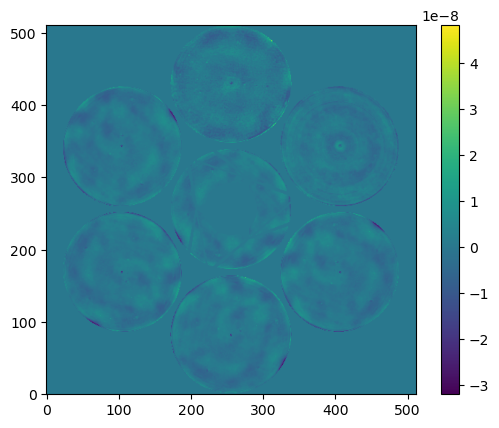

In [23]:
fig, ax = plt.subplots()
h = ax.imshow(src.phase.host(), origin='lower')
fig.colorbar(h,ax=ax)

In [24]:
# "aberrated" GMT WFE RMS [nm] & PSSn
src.wavefront.rms(-9),gmt.PSSn(src,**pssn_data)

(array([3.111922], dtype=float32), array([0.99964785]))